In [1]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import sys
sys.path.append("../code/")
import numpy as np
import pandas as pd
from dataloader import APPLIANCE_ORDER, get_train_test


num_folds = 5


In [3]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
appliance = "hvac"


appliance_num = APPLIANCE_ORDER.index(appliance)


In [43]:
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum
from keras import regularizers
agg_input = keras.layers.Input(shape=[25],name='Aggregate')
agg_input = keras.layers.BatchNormalization()(agg_input)




appliance_dense_1 = keras.layers.Dense(units=60,name='Appliance-layer-1',activation='relu')(agg_input)
appliance_bn = keras.layers.BatchNormalization()(appliance_dense_1)
dropout = keras.layers.Dropout(rate=0.1,name='Droput-Appliance')(appliance_bn)




out = keras.layers.Dense(units=1,name='Appliance-output',activation='relu')(dropout)
#out = Minimum(name='Clip-to-agg')([out, agg_input])


model = keras.Model(agg_input, out)

/Users/nipun/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1574: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_3" was not an Input tensor, it was generated by layer batch_normalization_4.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: batch_normalization_4/cond/Merge:0
  str(x.name))


TypeError: Input layers to a `Model` must be `InputLayer` objects. Received inputs: Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 25), dtype=float32). Input 0 (0-based) originates from layer type `BatchNormalization`.

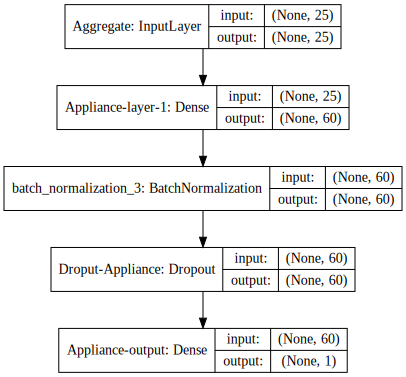

In [21]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [22]:
model.compile('adam','mean_absolute_error')

In [23]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
d=pd.DataFrame(oh.fit_transform(np.array(range(1, 25)).reshape(-1, 1)).toarray())

fold_num = 0
appliance_num = APPLIANCE_ORDER.index(appliance)
train, test = get_train_test(1, num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

train_appliance = train[:, appliance_num, :, :].reshape(-1,1)
test_appliance = test[:, appliance_num, :, :].reshape(-1, 1)

train_aggregate_time = np.zeros((train_aggregate.shape[0], 24, 25))
test_aggregate_time = np.zeros((test_aggregate.shape[0], 24, 25))


for home in range(train_aggregate.shape[0]):
    temp = d.copy()
    temp['power'] = train_aggregate[home, :, :]
    train_aggregate_time[home, :, :] = temp.values

for home in range(test_aggregate.shape[0]):
    temp = d.copy()
    temp['power'] = test_aggregate[home, :, :]
    test_aggregate_time[home, :, :] = temp.values
    
tr_agg = train_aggregate_time.reshape(-1, 25)
te_agg = test_aggregate_time.reshape(-1, 25)





In [38]:
model.fit(tr_agg ,train_appliance, epochs=20, validation_split=0.1)


Train on 130636 samples, validate on 14516 samples
Epoch 1/20
130636/130636 [==============================] - 5s 42us/step - loss: 213.8691 - val_loss: 283.7583
Epoch 2/20
130636/130636 [==============================] - 5s 41us/step - loss: 218.7812 - val_loss: 206.0123
Epoch 3/20
130636/130636 [==============================] - 5s 42us/step - loss: 217.5342 - val_loss: 160.1241
Epoch 4/20
130636/130636 [==============================] - 6s 46us/step - loss: 216.0054 - val_loss: 128.8608
Epoch 5/20
130636/130636 [==============================] - 5s 42us/step - loss: 214.0833 - val_loss: 152.8342
Epoch 6/20
130636/130636 [==============================] - 6s 48us/step - loss: 218.9402 - val_loss: 167.0258
Epoch 7/20
130636/130636 [==============================] - 7s 50us/step - loss: 221.8388 - val_loss: 132.2530
Epoch 8/20
130636/130636 [==============================] - 5s 40us/step - loss: 222.2079 - val_loss: 139.3665
Epoch 9/20
130636/130636 [==============================] - 5

In [39]:
pred = model.predict(te_agg)

In [40]:
te_agg[:, 24]

array([ 314.36666413,  308.79999951,  284.51667328, ...,  224.04999733,
        595.64997101,  474.61667633])

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred, test_appliance)

127.36250374329443

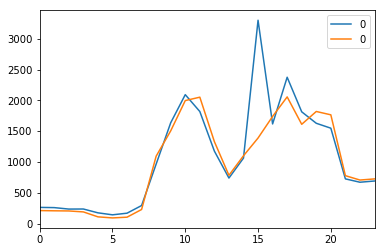

In [41]:
ax = pd.DataFrame(pred[:24]).plot()
pd.DataFrame(test_appliance[:24]).plot(ax=ax)

In [55]:

mean_absolute_error(np.concatenate(preds), np.concatenate(gts))

NameError: name 'mean_absolute_error' is not defined

In [126]:
gts = []
preds = []
for fold_num in range(5):
    print("---FOLD {} ----".format(fold_num))
    train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
    
    train_aggregate = train[:, 0, :, :].reshape(-1, 24)

    test_aggregate = test[:, 0, :, :].reshape(-1, 24)

    train_appliance = train[:, appliance_num, :, :].reshape(-1, 24)
    test_appliance = test[:, appliance_num, :, :].reshape( -1, 24)
    pred_appliance = learn(train_aggregate, train_appliance, test_aggregate)
    gts.append(test_appliance)
    preds.append(pred_appliance)

---FOLD 0 ----
Train on 5443 samples, validate on 605 samples
Epoch 1/30
5443/5443 [==============================] - 1s 194us/step - loss: 73.1283 - val_loss: 52.3770
Epoch 2/30
5443/5443 [==============================] - 0s 48us/step - loss: 73.0440 - val_loss: 52.3354
Epoch 3/30
5443/5443 [==============================] - 0s 48us/step - loss: 73.0198 - val_loss: 52.3115
Epoch 4/30
5443/5443 [==============================] - 0s 47us/step - loss: 73.0042 - val_loss: 52.3047
Epoch 5/30
5443/5443 [==============================] - 0s 62us/step - loss: 72.9862 - val_loss: 52.2962
Epoch 6/30
5443/5443 [==============================] - 0s 51us/step - loss: 72.9709 - val_loss: 52.2949
Epoch 7/30
5443/5443 [==============================] - 0s 49us/step - loss: 72.9521 - val_loss: 52.2987
Epoch 8/30
5443/5443 [==============================] - 0s 57us/step - loss: 72.9363 - val_loss: 52.2762
Epoch 9/30
5443/5443 [==============================] - 0s 48us/step - loss: 72.9188 - val_loss: 

Epoch 17/30
5443/5443 [==============================] - 0s 47us/step - loss: 66.9639 - val_loss: 52.1329
Epoch 18/30
5443/5443 [==============================] - 0s 51us/step - loss: 66.9346 - val_loss: 52.1203
Epoch 19/30
5443/5443 [==============================] - 0s 64us/step - loss: 66.8919 - val_loss: 52.0977
Epoch 20/30
5443/5443 [==============================] - 0s 53us/step - loss: 66.8421 - val_loss: 52.0546
Epoch 21/30
5443/5443 [==============================] - 0s 46us/step - loss: 66.8011 - val_loss: 52.0091
Epoch 22/30
5443/5443 [==============================] - 0s 44us/step - loss: 66.7173 - val_loss: 51.9876
Epoch 23/30
5443/5443 [==============================] - 0s 47us/step - loss: 66.6629 - val_loss: 51.9450
Epoch 24/30
5443/5443 [==============================] - 0s 58us/step - loss: 66.6072 - val_loss: 51.9158
Epoch 25/30
5443/5443 [==============================] - 0s 54us/step - loss: 66.5553 - val_loss: 51.8828
Epoch 26/30
5443/5443 [=======================

array([[ 0.2       ,  0.26666668,  0.2       , ...,  1.41666663,
         1.26666665,  2.6833334 ],
       [ 1.64999998,  1.36666667,  0.64999998, ...,  0.33333334,
         1.64999998,  1.68333328],
       [ 0.63333333,  0.55000001,  0.98333335, ...,  1.63333333,
         0.64999998,  0.66666669],
       ..., 
       [ 0.2       ,  0.34999999,  0.        , ...,  0.05      ,
         0.        ,  0.05      ],
       [ 0.        ,  0.        ,  0.05      , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.55000001,
         0.55000001,  0.34999999]])

In [100]:
APPLIANCE_ORDER

['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw']

In [107]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 60)           1500        Aggregate[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 60)           240         Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 60)           0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
Appliance-

In [109]:
pred = model.predict(test_aggregate)

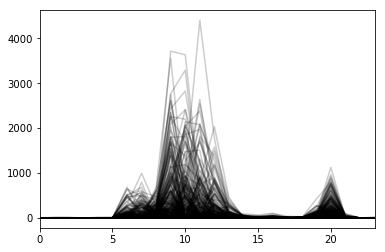

In [111]:
pd.DataFrame(pred).T.plot(legend=False, color='k',alpha=0.2)

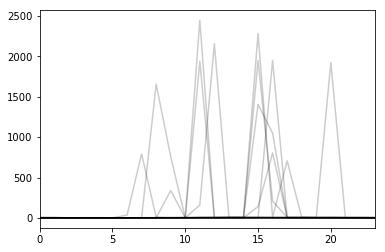

In [121]:
pd.DataFrame(test_appliance[:20]).T.plot(legend=False, color='k',alpha=0.2)

In [110]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_appliance, pred)

67.313343553566867

In [31]:
pred_appliance = {}
num_iterations_dictionary = {'hvac':1200,'fridge':500,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[1:]:
    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    from keras import regularizers
    agg_input = keras.layers.Input(shape=[24],name='Aggregate')
    appliance_dense_1 = keras.layers.Dense(units=20,name='Appliance-layer-1',activation='relu')(agg_input)
    appliance_bn = keras.layers.BatchNormalization()(appliance_dense_1)
    dropout = keras.layers.Dropout(rate=0.1,name='Droput-Appliance')(appliance_bn)




    out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
    out = Minimum(name='Clip-to-agg')([out, agg_input])


    model = keras.Model(agg_input, out)
    model.compile('adam','mean_absolute_error')
    model.fit(train_agg, train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg)



hvac
********************
Train on 378 samples, validate on 42 samples
Epoch 1/1200
378/378 [==============================] - 1s 2ms/step - loss: 861.6758 - val_loss: 873.3601
Epoch 2/1200
378/378 [==============================] - 0s 65us/step - loss: 861.6250 - val_loss: 873.5482
Epoch 3/1200
378/378 [==============================] - 0s 72us/step - loss: 861.5760 - val_loss: 873.6012
Epoch 4/1200
378/378 [==============================] - 0s 69us/step - loss: 861.5365 - val_loss: 873.5959
Epoch 5/1200
378/378 [==============================] - 0s 63us/step - loss: 861.4762 - val_loss: 873.5596
Epoch 6/1200
378/378 [==============================] - 0s 57us/step - loss: 861.4200 - val_loss: 873.4823
Epoch 7/1200
378/378 [==============================] - 0s 65us/step - loss: 861.3570 - val_loss: 873.4054
Epoch 8/1200
378/378 [==============================] - 0s 58us/step - loss: 861.2753 - val_loss: 873.3150
Epoch 9/1200
378/378 [==============================] - 0s 59us/step - los

Epoch 76/1200
378/378 [==============================] - 0s 71us/step - loss: 821.8676 - val_loss: 839.4928
Epoch 77/1200
378/378 [==============================] - 0s 62us/step - loss: 820.9967 - val_loss: 838.3092
Epoch 78/1200
378/378 [==============================] - 0s 67us/step - loss: 820.4025 - val_loss: 836.8970
Epoch 79/1200
378/378 [==============================] - 0s 66us/step - loss: 819.4352 - val_loss: 836.1084
Epoch 80/1200
378/378 [==============================] - 0s 60us/step - loss: 817.9449 - val_loss: 835.1929
Epoch 81/1200
378/378 [==============================] - 0s 65us/step - loss: 817.1013 - val_loss: 834.1696
Epoch 82/1200
378/378 [==============================] - 0s 64us/step - loss: 816.0722 - val_loss: 833.7141
Epoch 83/1200
378/378 [==============================] - 0s 64us/step - loss: 815.0462 - val_loss: 833.4419
Epoch 84/1200
378/378 [==============================] - 0s 73us/step - loss: 814.2793 - val_loss: 832.0678
Epoch 85/1200
378/378 [=====

Epoch 226/1200
378/378 [==============================] - 0s 64us/step - loss: 591.0601 - val_loss: 667.7407
Epoch 227/1200
378/378 [==============================] - 0s 72us/step - loss: 590.2017 - val_loss: 672.0573
Epoch 228/1200
378/378 [==============================] - 0s 62us/step - loss: 587.4802 - val_loss: 673.0465
Epoch 229/1200
378/378 [==============================] - 0s 71us/step - loss: 584.5988 - val_loss: 670.6803
Epoch 230/1200
378/378 [==============================] - 0s 68us/step - loss: 582.6109 - val_loss: 668.3926
Epoch 231/1200
378/378 [==============================] - 0s 53us/step - loss: 580.0059 - val_loss: 666.4742
Epoch 232/1200
378/378 [==============================] - 0s 56us/step - loss: 580.6943 - val_loss: 662.2218
Epoch 233/1200
378/378 [==============================] - 0s 55us/step - loss: 578.3093 - val_loss: 663.7275
Epoch 234/1200
378/378 [==============================] - 0s 51us/step - loss: 578.7892 - val_loss: 660.7896
Epoch 235/1200
378/

Epoch 301/1200
378/378 [==============================] - 0s 56us/step - loss: 466.8226 - val_loss: 564.1934
Epoch 302/1200
378/378 [==============================] - 0s 60us/step - loss: 465.5623 - val_loss: 567.4359
Epoch 303/1200
378/378 [==============================] - 0s 64us/step - loss: 461.6911 - val_loss: 568.5410
Epoch 304/1200
378/378 [==============================] - 0s 57us/step - loss: 461.6834 - val_loss: 567.2562
Epoch 305/1200
378/378 [==============================] - 0s 65us/step - loss: 461.4503 - val_loss: 563.1809
Epoch 306/1200
378/378 [==============================] - 0s 62us/step - loss: 456.8970 - val_loss: 560.1777
Epoch 307/1200
378/378 [==============================] - 0s 68us/step - loss: 458.7173 - val_loss: 559.7529
Epoch 308/1200
378/378 [==============================] - 0s 70us/step - loss: 461.2059 - val_loss: 566.4567
Epoch 309/1200
378/378 [==============================] - 0s 61us/step - loss: 456.1499 - val_loss: 571.1294
Epoch 310/1200
378/

378/378 [==============================] - 0s 72us/step - loss: 298.5943 - val_loss: 350.4925
Epoch 452/1200
378/378 [==============================] - 0s 70us/step - loss: 296.5991 - val_loss: 348.6069
Epoch 453/1200
378/378 [==============================] - 0s 73us/step - loss: 291.8966 - val_loss: 347.9338
Epoch 454/1200
378/378 [==============================] - 0s 69us/step - loss: 285.3122 - val_loss: 347.9650
Epoch 455/1200
378/378 [==============================] - 0s 67us/step - loss: 287.5591 - val_loss: 350.1213
Epoch 456/1200
378/378 [==============================] - 0s 68us/step - loss: 289.0762 - val_loss: 349.7348
Epoch 457/1200
378/378 [==============================] - 0s 67us/step - loss: 293.2203 - val_loss: 345.8786
Epoch 458/1200
378/378 [==============================] - 0s 69us/step - loss: 288.0536 - val_loss: 346.4514
Epoch 459/1200
378/378 [==============================] - 0s 68us/step - loss: 280.2823 - val_loss: 346.7843
Epoch 460/1200
378/378 [==========

Epoch 601/1200
378/378 [==============================] - 0s 69us/step - loss: 195.9973 - val_loss: 241.6939
Epoch 602/1200
378/378 [==============================] - 0s 72us/step - loss: 195.1185 - val_loss: 242.0318
Epoch 603/1200
378/378 [==============================] - 0s 74us/step - loss: 197.5129 - val_loss: 242.7992
Epoch 604/1200
378/378 [==============================] - 0s 62us/step - loss: 198.0263 - val_loss: 243.1244
Epoch 605/1200
378/378 [==============================] - 0s 67us/step - loss: 197.1979 - val_loss: 243.4956
Epoch 606/1200
378/378 [==============================] - 0s 64us/step - loss: 195.3220 - val_loss: 243.4562
Epoch 607/1200
378/378 [==============================] - 0s 63us/step - loss: 189.8853 - val_loss: 243.9957
Epoch 608/1200
378/378 [==============================] - 0s 59us/step - loss: 192.3356 - val_loss: 245.0779
Epoch 609/1200
378/378 [==============================] - 0s 60us/step - loss: 198.8262 - val_loss: 245.1820
Epoch 610/1200
378/

378/378 [==============================] - 0s 69us/step - loss: 143.8401 - val_loss: 179.4809
Epoch 752/1200
378/378 [==============================] - 0s 73us/step - loss: 141.1121 - val_loss: 179.0129
Epoch 753/1200
378/378 [==============================] - 0s 59us/step - loss: 141.8423 - val_loss: 177.7560
Epoch 754/1200
378/378 [==============================] - 0s 64us/step - loss: 142.8218 - val_loss: 176.9243
Epoch 755/1200
378/378 [==============================] - 0s 58us/step - loss: 140.0450 - val_loss: 177.1064
Epoch 756/1200
378/378 [==============================] - 0s 65us/step - loss: 140.6023 - val_loss: 177.6994
Epoch 757/1200
378/378 [==============================] - 0s 57us/step - loss: 144.2093 - val_loss: 178.8064
Epoch 758/1200
378/378 [==============================] - 0s 58us/step - loss: 141.0330 - val_loss: 178.9154
Epoch 759/1200
378/378 [==============================] - 0s 56us/step - loss: 144.4634 - val_loss: 176.8519
Epoch 760/1200
378/378 [==========

378/378 [==============================] - 0s 58us/step - loss: 131.2487 - val_loss: 157.5953
Epoch 902/1200
378/378 [==============================] - 0s 60us/step - loss: 128.8343 - val_loss: 157.2367
Epoch 903/1200
378/378 [==============================] - 0s 62us/step - loss: 128.8887 - val_loss: 157.4135
Epoch 904/1200
378/378 [==============================] - 0s 65us/step - loss: 129.7206 - val_loss: 157.2423
Epoch 905/1200
378/378 [==============================] - 0s 58us/step - loss: 128.5323 - val_loss: 156.6119
Epoch 906/1200
378/378 [==============================] - 0s 63us/step - loss: 128.8117 - val_loss: 156.1647
Epoch 907/1200
378/378 [==============================] - 0s 62us/step - loss: 128.3200 - val_loss: 157.0516
Epoch 908/1200
378/378 [==============================] - 0s 73us/step - loss: 130.3164 - val_loss: 156.7784
Epoch 909/1200
378/378 [==============================] - 0s 62us/step - loss: 128.7272 - val_loss: 156.5041
Epoch 910/1200
378/378 [==========

378/378 [==============================] - 0s 60us/step - loss: 125.2956 - val_loss: 142.1063
Epoch 1051/1200
378/378 [==============================] - 0s 66us/step - loss: 124.9575 - val_loss: 142.0573
Epoch 1052/1200
378/378 [==============================] - 0s 66us/step - loss: 125.7557 - val_loss: 142.2309
Epoch 1053/1200
378/378 [==============================] - 0s 60us/step - loss: 124.8284 - val_loss: 142.2785
Epoch 1054/1200
378/378 [==============================] - 0s 73us/step - loss: 125.0709 - val_loss: 141.6630
Epoch 1055/1200
378/378 [==============================] - 0s 61us/step - loss: 124.2905 - val_loss: 141.4887
Epoch 1056/1200
378/378 [==============================] - 0s 60us/step - loss: 124.9071 - val_loss: 141.7251
Epoch 1057/1200
378/378 [==============================] - 0s 66us/step - loss: 124.4817 - val_loss: 141.7464
Epoch 1058/1200
378/378 [==============================] - 0s 63us/step - loss: 124.8999 - val_loss: 142.0220
Epoch 1059/1200
378/378 [=

378/378 [==============================] - 0s 72us/step - loss: 123.0695 - val_loss: 142.0170
Epoch 1199/1200
378/378 [==============================] - 0s 69us/step - loss: 123.9528 - val_loss: 141.8256
Epoch 1200/1200
378/378 [==============================] - 0s 60us/step - loss: 123.4059 - val_loss: 141.9478
fridge
********************
Train on 378 samples, validate on 42 samples
Epoch 1/500
378/378 [==============================] - 1s 2ms/step - loss: 88.1316 - val_loss: 95.8144
Epoch 2/500
378/378 [==============================] - 0s 57us/step - loss: 88.0745 - val_loss: 96.2379
Epoch 3/500
378/378 [==============================] - 0s 62us/step - loss: 88.0268 - val_loss: 96.3581
Epoch 4/500
378/378 [==============================] - 0s 58us/step - loss: 87.9702 - val_loss: 96.4108
Epoch 5/500
378/378 [==============================] - 0s 65us/step - loss: 87.9054 - val_loss: 96.4465
Epoch 6/500
378/378 [==============================] - 0s 58us/step - loss: 87.8276 - val_loss

378/378 [==============================] - 0s 60us/step - loss: 48.7455 - val_loss: 58.7200
Epoch 153/500
378/378 [==============================] - 0s 69us/step - loss: 48.3835 - val_loss: 58.7535
Epoch 154/500
378/378 [==============================] - 0s 61us/step - loss: 47.9729 - val_loss: 58.5803
Epoch 155/500
378/378 [==============================] - 0s 59us/step - loss: 47.7768 - val_loss: 58.4102
Epoch 156/500
378/378 [==============================] - 0s 54us/step - loss: 47.9975 - val_loss: 58.4240
Epoch 157/500
378/378 [==============================] - 0s 55us/step - loss: 47.5548 - val_loss: 58.2681
Epoch 158/500
378/378 [==============================] - 0s 68us/step - loss: 47.4685 - val_loss: 58.0900
Epoch 159/500
378/378 [==============================] - ETA: 0s - loss: 42.86 - 0s 63us/step - loss: 47.5154 - val_loss: 57.7013
Epoch 160/500
378/378 [==============================] - 0s 68us/step - loss: 47.1863 - val_loss: 57.4743
Epoch 161/500
378/378 [=============

Epoch 229/500
378/378 [==============================] - 0s 61us/step - loss: 36.5264 - val_loss: 46.8311
Epoch 230/500
378/378 [==============================] - 0s 59us/step - loss: 36.4357 - val_loss: 46.5030
Epoch 231/500
378/378 [==============================] - 0s 61us/step - loss: 35.9429 - val_loss: 46.4659
Epoch 232/500
378/378 [==============================] - 0s 59us/step - loss: 36.0450 - val_loss: 46.5706
Epoch 233/500
378/378 [==============================] - 0s 60us/step - loss: 35.4820 - val_loss: 46.6719
Epoch 234/500
378/378 [==============================] - 0s 61us/step - loss: 35.6763 - val_loss: 46.7527
Epoch 235/500
378/378 [==============================] - 0s 56us/step - loss: 35.2906 - val_loss: 46.6468
Epoch 236/500
378/378 [==============================] - 0s 57us/step - loss: 35.1209 - val_loss: 45.9970
Epoch 237/500
378/378 [==============================] - 0s 58us/step - loss: 34.6649 - val_loss: 45.5891
Epoch 238/500
378/378 [=======================

378/378 [==============================] - 0s 71us/step - loss: 26.4543 - val_loss: 37.5263
Epoch 383/500
378/378 [==============================] - 0s 67us/step - loss: 25.6554 - val_loss: 37.3908
Epoch 384/500
378/378 [==============================] - 0s 62us/step - loss: 25.6309 - val_loss: 37.2594
Epoch 385/500
378/378 [==============================] - 0s 61us/step - loss: 25.7620 - val_loss: 37.3892
Epoch 386/500
378/378 [==============================] - 0s 65us/step - loss: 26.2300 - val_loss: 37.3910
Epoch 387/500
378/378 [==============================] - 0s 63us/step - loss: 25.8049 - val_loss: 37.2997
Epoch 388/500
378/378 [==============================] - 0s 65us/step - loss: 26.2075 - val_loss: 37.3389
Epoch 389/500
378/378 [==============================] - 0s 71us/step - loss: 25.8600 - val_loss: 37.4664
Epoch 390/500
378/378 [==============================] - 0s 58us/step - loss: 25.7242 - val_loss: 37.4238
Epoch 391/500
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 60us/step - loss: 5.4370 - val_loss: 6.5938
Epoch 37/250
378/378 [==============================] - 0s 61us/step - loss: 5.3771 - val_loss: 6.5750
Epoch 38/250
378/378 [==============================] - 0s 60us/step - loss: 5.3928 - val_loss: 6.4727
Epoch 39/250
378/378 [==============================] - 0s 55us/step - loss: 5.3832 - val_loss: 6.4049
Epoch 40/250
378/378 [==============================] - 0s 61us/step - loss: 5.3568 - val_loss: 6.3898
Epoch 41/250
378/378 [==============================] - 0s 53us/step - loss: 5.3282 - val_loss: 6.3975
Epoch 42/250
378/378 [==============================] - 0s 54us/step - loss: 5.3410 - val_loss: 6.3897
Epoch 43/250
378/378 [==============================] - 0s 59us/step - loss: 5.3318 - val_loss: 6.3251
Epoch 44/250
378/378 [==============================] - 0s 56us/step - loss: 5.3022 - val_loss: 6.2650
Epoch 45/250
378/378 [==============================] - 0s 58us/step - loss: 5.3325 - 

378/378 [==============================] - 0s 59us/step - loss: 4.9696 - val_loss: 6.0797
Epoch 116/250
378/378 [==============================] - 0s 64us/step - loss: 4.9577 - val_loss: 6.0551
Epoch 117/250
378/378 [==============================] - 0s 58us/step - loss: 4.9623 - val_loss: 6.1042
Epoch 118/250
378/378 [==============================] - 0s 55us/step - loss: 4.9707 - val_loss: 6.0335
Epoch 119/250
378/378 [==============================] - 0s 72us/step - loss: 5.0024 - val_loss: 6.0284
Epoch 120/250
378/378 [==============================] - 0s 73us/step - loss: 4.9581 - val_loss: 6.0330
Epoch 121/250
378/378 [==============================] - 0s 62us/step - loss: 4.9609 - val_loss: 6.0524
Epoch 122/250
378/378 [==============================] - 0s 74us/step - loss: 4.9240 - val_loss: 6.0314
Epoch 123/250
378/378 [==============================] - 0s 73us/step - loss: 4.9939 - val_loss: 6.0547
Epoch 124/250
378/378 [==============================] - 0s 59us/step - loss: 

378/378 [==============================] - 0s 60us/step - loss: 13.4626 - val_loss: 15.1969
Epoch 21/250
378/378 [==============================] - 0s 62us/step - loss: 13.4582 - val_loss: 15.1886
Epoch 22/250
378/378 [==============================] - 0s 66us/step - loss: 13.4515 - val_loss: 15.1808
Epoch 23/250
378/378 [==============================] - 0s 68us/step - loss: 13.4535 - val_loss: 15.1700
Epoch 24/250
378/378 [==============================] - 0s 65us/step - loss: 13.4502 - val_loss: 15.1639
Epoch 25/250
378/378 [==============================] - 0s 74us/step - loss: 13.4486 - val_loss: 15.1594
Epoch 26/250
378/378 [==============================] - 0s 74us/step - loss: 13.4426 - val_loss: 15.1569
Epoch 27/250
378/378 [==============================] - 0s 71us/step - loss: 13.4424 - val_loss: 15.1533
Epoch 28/250
378/378 [==============================] - 0s 64us/step - loss: 13.4396 - val_loss: 15.1513
Epoch 29/250
378/378 [==============================] - 0s 64us/step

Epoch 98/250
378/378 [==============================] - 0s 71us/step - loss: 13.3463 - val_loss: 15.1098
Epoch 99/250
378/378 [==============================] - 0s 63us/step - loss: 13.3554 - val_loss: 15.1098
Epoch 100/250
378/378 [==============================] - 0s 73us/step - loss: 13.3591 - val_loss: 15.1103
Epoch 101/250
378/378 [==============================] - 0s 74us/step - loss: 13.3534 - val_loss: 15.1135
Epoch 102/250
378/378 [==============================] - 0s 68us/step - loss: 13.3427 - val_loss: 15.1174
Epoch 103/250
378/378 [==============================] - 0s 64us/step - loss: 13.3326 - val_loss: 15.1210
Epoch 104/250
378/378 [==============================] - 0s 66us/step - loss: 13.3441 - val_loss: 15.1213
Epoch 105/250
378/378 [==============================] - 0s 63us/step - loss: 13.3416 - val_loss: 15.1260
Epoch 106/250
378/378 [==============================] - 0s 63us/step - loss: 13.3240 - val_loss: 15.1266
Epoch 107/250
378/378 [=========================

Epoch 2/300
378/378 [==============================] - 0s 59us/step - loss: 4.9455 - val_loss: 5.3586
Epoch 3/300
378/378 [==============================] - 0s 65us/step - loss: 4.9205 - val_loss: 5.1274
Epoch 4/300
378/378 [==============================] - 0s 61us/step - loss: 4.8909 - val_loss: 4.9769
Epoch 5/300
378/378 [==============================] - 0s 64us/step - loss: 4.8735 - val_loss: 4.8782
Epoch 6/300
378/378 [==============================] - 0s 62us/step - loss: 4.8586 - val_loss: 4.8188
Epoch 7/300
378/378 [==============================] - 0s 64us/step - loss: 4.8410 - val_loss: 4.7703
Epoch 8/300
378/378 [==============================] - 0s 61us/step - loss: 4.8296 - val_loss: 4.7314
Epoch 9/300
378/378 [==============================] - 0s 56us/step - loss: 4.8108 - val_loss: 4.6850
Epoch 10/300
378/378 [==============================] - 0s 56us/step - loss: 4.8011 - val_loss: 4.6565
Epoch 11/300
378/378 [==============================] - 0s 77us/step - loss: 4.79

Epoch 160/300
378/378 [==============================] - 0s 57us/step - loss: 4.6609 - val_loss: 4.4387
Epoch 161/300
378/378 [==============================] - 0s 56us/step - loss: 4.6489 - val_loss: 4.4361
Epoch 162/300
378/378 [==============================] - 0s 61us/step - loss: 4.6309 - val_loss: 4.4363
Epoch 163/300
378/378 [==============================] - 0s 56us/step - loss: 4.6325 - val_loss: 4.4374
Epoch 164/300
378/378 [==============================] - 0s 52us/step - loss: 4.6371 - val_loss: 4.4353
Epoch 165/300
378/378 [==============================] - 0s 59us/step - loss: 4.6313 - val_loss: 4.4399
Epoch 166/300
378/378 [==============================] - 0s 55us/step - loss: 4.6454 - val_loss: 4.4449
Epoch 167/300
378/378 [==============================] - 0s 56us/step - loss: 4.6466 - val_loss: 4.4436
Epoch 168/300
378/378 [==============================] - 0s 58us/step - loss: 4.6381 - val_loss: 4.4428
Epoch 169/300
378/378 [==============================] - 0s 52us

Epoch 239/300
378/378 [==============================] - 0s 59us/step - loss: 4.6076 - val_loss: 4.4532
Epoch 240/300
378/378 [==============================] - 0s 57us/step - loss: 4.6164 - val_loss: 4.4488
Epoch 241/300
378/378 [==============================] - 0s 51us/step - loss: 4.5981 - val_loss: 4.4458
Epoch 242/300
378/378 [==============================] - 0s 59us/step - loss: 4.6040 - val_loss: 4.4471
Epoch 243/300
378/378 [==============================] - 0s 56us/step - loss: 4.6206 - val_loss: 4.4631
Epoch 244/300
378/378 [==============================] - 0s 51us/step - loss: 4.6129 - val_loss: 4.4534
Epoch 245/300
378/378 [==============================] - 0s 56us/step - loss: 4.6025 - val_loss: 4.4458
Epoch 246/300
378/378 [==============================] - 0s 53us/step - loss: 4.6084 - val_loss: 4.4474
Epoch 247/300
378/378 [==============================] - ETA: 0s - loss: 7.564 - 0s 54us/step - loss: 4.5964 - val_loss: 4.4446
Epoch 248/300
378/378 [=================

Epoch 17/250
378/378 [==============================] - 0s 55us/step - loss: 13.5821 - val_loss: 13.2883
Epoch 18/250
378/378 [==============================] - 0s 52us/step - loss: 13.5197 - val_loss: 13.3014
Epoch 19/250
378/378 [==============================] - 0s 56us/step - loss: 13.4837 - val_loss: 13.2723
Epoch 20/250
378/378 [==============================] - 0s 55us/step - loss: 13.4286 - val_loss: 13.2868
Epoch 21/250
378/378 [==============================] - 0s 51us/step - loss: 13.3946 - val_loss: 13.2863
Epoch 22/250
378/378 [==============================] - 0s 63us/step - loss: 13.3367 - val_loss: 13.2780
Epoch 23/250
378/378 [==============================] - 0s 55us/step - loss: 13.3210 - val_loss: 13.2940
Epoch 24/250
378/378 [==============================] - 0s 55us/step - loss: 13.2533 - val_loss: 13.2760
Epoch 25/250
378/378 [==============================] - 0s 56us/step - loss: 13.2190 - val_loss: 13.2820
Epoch 26/250
378/378 [==============================] -

Epoch 95/250
378/378 [==============================] - 0s 74us/step - loss: 12.0257 - val_loss: 13.1205
Epoch 96/250
378/378 [==============================] - 0s 64us/step - loss: 11.9951 - val_loss: 13.1246
Epoch 97/250
378/378 [==============================] - ETA: 0s - loss: 10.69 - 0s 89us/step - loss: 12.0674 - val_loss: 13.1457
Epoch 98/250
378/378 [==============================] - 0s 78us/step - loss: 12.0259 - val_loss: 13.1659
Epoch 99/250
378/378 [==============================] - 0s 69us/step - loss: 11.9749 - val_loss: 13.1664
Epoch 100/250
378/378 [==============================] - 0s 79us/step - loss: 11.9560 - val_loss: 13.0951
Epoch 101/250
378/378 [==============================] - 0s 78us/step - loss: 12.0005 - val_loss: 13.0897
Epoch 102/250
378/378 [==============================] - 0s 76us/step - loss: 11.9437 - val_loss: 13.0936
Epoch 103/250
378/378 [==============================] - 0s 64us/step - loss: 11.9355 - val_loss: 13.1093
Epoch 104/250
378/378 [====

Epoch 172/250
378/378 [==============================] - 0s 115us/step - loss: 11.7555 - val_loss: 13.3134
Epoch 173/250
378/378 [==============================] - 0s 103us/step - loss: 11.7572 - val_loss: 13.2935
Epoch 174/250
378/378 [==============================] - ETA: 0s - loss: 5.705 - 0s 81us/step - loss: 11.8272 - val_loss: 13.3853
Epoch 175/250
378/378 [==============================] - 0s 85us/step - loss: 11.7173 - val_loss: 13.3733
Epoch 176/250
378/378 [==============================] - 0s 83us/step - loss: 11.7760 - val_loss: 13.4292
Epoch 177/250
378/378 [==============================] - 0s 95us/step - loss: 11.7964 - val_loss: 13.4054
Epoch 178/250
378/378 [==============================] - 0s 88us/step - loss: 11.7681 - val_loss: 13.5772
Epoch 179/250
378/378 [==============================] - 0s 84us/step - loss: 11.8035 - val_loss: 13.5072
Epoch 180/250
378/378 [==============================] - 0s 101us/step - loss: 11.7398 - val_loss: 13.5268
Epoch 181/250
378/3

Epoch 249/250
378/378 [==============================] - 0s 89us/step - loss: 11.7504 - val_loss: 13.5561
Epoch 250/250
378/378 [==============================] - 0s 80us/step - loss: 11.6725 - val_loss: 13.5580


In [32]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 20)           80          Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 20)           0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
Appliance-

In [34]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [35]:
pd.Series(mae)

dw         14.758426
fridge     32.523749
hvac      140.924952
mw          6.328504
oven       18.878965
wm          5.767657
dtype: float64

In [34]:
pd.Series(mae)

dw         14.515641
fridge     42.986721
hvac      135.127259
mw          6.303220
oven       19.784436
wm          5.618949
dtype: float64

In [24]:
pred_hvac.shape

(308, 24)

In [2]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




NameError: name 'model' is not defined

In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

In [1]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()

NameError: name 'pd' is not defined